In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import trimesh

scene = trimesh.Scene()

In [2]:
import os

base_dir = '/lustre/mlnvme/data/s94zalek_hpc-shape_matching/SURREAL'

# target_dir = '/tmp'
# # copy all files from base_dir to target_dir using !rsync
# os.system(f'rsync -av {base_dir} {target_dir}')

In [3]:
# get all zip files in 
zip_files_path_list = []
for file in os.listdir(base_dir):
    if file.endswith('.zip'):
        zip_files_path_list.append(os.path.join(base_dir, file))
        
zip_files_path_list.sort()

print(zip_files_path_list)

['/lustre/mlnvme/data/s94zalek_hpc-shape_matching/SURREAL/000000_010000.zip', '/lustre/mlnvme/data/s94zalek_hpc-shape_matching/SURREAL/010000_020000.zip']


In [4]:
from my_code.datasets.cached.zip_shape_dataset import ZipFileDataset, ZipCollection
from tqdm import tqdm

zip_files = ZipCollection(zip_files_path_list)
dataset = ZipFileDataset(zip_files.open(), 128)


Opening 2 zip files...


In [7]:
zip_files.close()

Closing 2 zip files...


In [5]:
import networks.diffusion_network as diffusion_network

condition_dim = 0
start_dim = 0

feature_dim = 32
evecs_per_support = 4


device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = diffusion_network.DiffusionNet(
    in_channels=feature_dim,
    out_channels=feature_dim // evecs_per_support,
    cache_dir=None,
    input_type='wks',
    k_eig=128,
    n_block=6
    ).to(device)

In [6]:
input_type = 'wks'
# net.load_state_dict(torch.load('/home/s94zalek_hpc/shape_matching/my_code/experiments/sign_double_start_0_feat_32_6block_factor4_dataset_SURREAL_train_rot_180_180_180_normal_True_noise_0.0_-0.05_0.05_lapl_mesh_scale_0.9_1.1_wks/40000.pth'))
net.load_state_dict(torch.load('/home/s94zalek_hpc/shape_matching/my_code/experiments/sign_estimator_no_aug/40000.pth'))

<All keys matched successfully>

In [ ]:
# add 4 random training shapes to trimesh scene

# np.random.shuffle(train_shapes)
scene.geometry.clear()

rand_idx_train = np.random.randint(0, len(dataset), 5)

for i, idx in enumerate(rand_idx_train):
    scene.add_geometry(trimesh.Trimesh(
        vertices=dataset[idx]['verts'] + torch.tensor([i, 0, 0]),
        faces=dataset[idx]['faces']))
    
axis = trimesh.creation.axis(axis_length=1)
scene.add_geometry(axis)
scene.show()

In [15]:

import importlib
importlib.reload(sign_training)

<module 'my_code.sign_canonicalization.training' from '/home/s94zalek_hpc/shape_matching/my_code/sign_canonicalization/training.py'>

In [13]:
from tqdm import tqdm
import utils.geometry_util as geometry_util
import robust_laplacian
import scipy.sparse.linalg as sla
import utils.geometry_util as geometry_util
import my_code.sign_canonicalization.training as sign_training


tqdm._instances.clear()
       
iterator = tqdm(range(2000000))
incorrect_signs_list = torch.tensor([])
curr_iter = 0

for epoch in range(len(iterator) // len(dataset_3dc)):
    
    # train_shapes_shuffled = train_shapes.copy()
    # np.random.shuffle(test_shapes_list)
    
    
    for curr_idx in range(1000, len(dataset_3dc)):     


        ##############################################
        # Select a shape
        ##############################################
        
        test_shape = dataset_3dc[curr_idx]['second']
        
        verts = test_shape['verts'].unsqueeze(0).to(device)
        faces = test_shape['faces'].unsqueeze(0).to(device)
        evecs_orig = test_shape['evecs'][:, start_dim:start_dim+feature_dim].unsqueeze(0).to(device)

        ##############################################
        # Set the signs on shape 0
        ##############################################

        # create a random combilation of +1 and -1, length = feature_dim
        sign_gt_0 = torch.randint(0, 2, (feature_dim,)).float().to(device)
        
        sign_gt_0[sign_gt_0 == 0] = -1
        sign_gt_0 = sign_gt_0.float().unsqueeze(0)

        # multiply evecs [6890 x 16] by sign_flip [16]
        evecs_flip_0 = evecs_orig * sign_gt_0
        
        # predict the sign change
        with torch.no_grad():
            sign_pred_0, supp_vec_0, _ = sign_training.predict_sign_change(
                net, verts, faces, evecs_flip_0, evecs_cond=None, input_type=input_type,
                # mass=test_shape['mass'].unsqueeze(0), L=test_shape['L'].unsqueeze(0),
                # evals=test_shape['evals'], evecs=test_shape['evecs'].unsqueeze(0),
                # gradX=test_shape['gradX'].unsqueeze(0), gradY=test_shape['gradY'].unsqueeze(0)
                )
        
        ##############################################
        # Set the signs on shape 1
        ##############################################
        
        # create a random combilation of +1 and -1, length = feature_dim
        sign_gt_1 = torch.randint(0, 2, (feature_dim,)).float().to(device)
        
        sign_gt_1[sign_gt_1 == 0] = -1
        sign_gt_1 = sign_gt_1.float().unsqueeze(0)
        
        # multiply evecs [6890 x 16] by sign_flip [16]
        evecs_flip_1 = evecs_orig * sign_gt_1
        
        # predict the sign change
        with torch.no_grad():
            sign_pred_1, supp_vec_1, _ = sign_training.predict_sign_change(
                net, verts, faces, evecs_flip_1, evecs_cond=None, input_type=input_type,
                # mass=test_shape['mass'].unsqueeze(0), L=test_shape['L'].unsqueeze(0),
                # evals=test_shape['evals'], evecs=test_shape['evecs'].unsqueeze(0),
                # gradX=test_shape['gradX'].unsqueeze(0), gradY=test_shape['gradY'].unsqueeze(0)
                )
        
        ##############################################
        # Calculate the loss
        ##############################################
        
        # calculate the ground truth sign difference
        sign_diff_gt = sign_gt_1 * sign_gt_0
        
        # calculate the sign difference between predicted evecs
        sign_diff_pred = sign_pred_1 * sign_pred_0
        
        sign_correct = sign_diff_pred.sign() * sign_diff_gt.sign() 
        
        
        # count the number of incorrect signs
        count_incorrect_signs = (sign_correct < 0).int().sum()
            
        # incorrect_signs_list.append(count_incorrect_signs)
        incorrect_signs_list = torch.cat([incorrect_signs_list, torch.tensor([count_incorrect_signs])])
        
        
        iterator.set_description(f'Mean incorrect signs {incorrect_signs_list.float().mean():.2f} / {feature_dim}, max {incorrect_signs_list.max()}')
        iterator.update(1)
        # if count_incorrect_signs > 7:
        #     raise ValueError('Too many incorrect signs')
    
    
print(f'Results for {len(incorrect_signs_list)} test shapes')
print(f'Incorrect signs per shape: {incorrect_signs_list.float().mean():.2f} / {feature_dim}')

print('Max incorrect signs', incorrect_signs_list.max())

print()
# print('Shape idx', curr_idx)
print('GT', sign_diff_gt)
print('PRED', sign_diff_pred)
print('Correct', sign_correct)
print(f'Incorrect signs {torch.sum(sign_correct != 1)} / {feature_dim}')
print(incorrect_signs_list)


# plt.plot(support_vector_norm.squeeze().detach().cpu().numpy(), '.', alpha=0.1)
# plt.ylim(-0.1, 0.1)
# # plt.yscale('log')
# plt.show()

Mean incorrect signs 0.19 / 32, max 1.0:   0%|                                                    | 16/2000000 [01:37<2708:22:44,  4.88s/it]

KeyboardInterrupt: 

In [89]:
tqdm._instances.clear()

In [91]:
len(dataset)

20000

In [ ]:
for i in tqdm(range(400, 420)):
    dataset[i]

In [26]:
importlib.reload(template_dataset)

<module 'my_code.datasets.template_dataset' from '/home/s94zalek_hpc/shape_matching/my_code/datasets/template_dataset.py'>

In [8]:
import my_code.datasets.template_dataset as template_dataset

dataset_double = template_dataset.TemplateDataset(
    base_dataset=dataset,
    template_path='data/SURREAL_full/template/template.ply',
    template_corr=list(range(6890)),
    num_evecs=dataset.k,
    preload_base_dataset=False,
    canonicalize_fmap=None,
    lb_cache_dir=None,
    centering='bbox'
)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [10]:
# dataset_double[10]

In [9]:
from tqdm import tqdm
import utils.geometry_util as geometry_util
import robust_laplacian
import scipy.sparse.linalg as sla
import utils.geometry_util as geometry_util
import my_code.sign_canonicalization.training as sign_training

In [73]:
def get_corrected_data(data, net, net_input_type, num_evecs):
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # device = 'cpu'
    
    verts_first = data['first']['verts'].unsqueeze(0).to(device)
    verts_second = data['second']['verts'].unsqueeze(0).to(device)
    
    faces_first = data['first']['faces'].unsqueeze(0).to(device)
    faces_second = data['second']['faces'].unsqueeze(0).to(device)

    evecs_first = data['first']['evecs'][:, :num_evecs].unsqueeze(0).to(device)
    evecs_second = data['second']['evecs'][:, :num_evecs].unsqueeze(0).to(device)

    corr_first = data['first']['corr']
    corr_second = data['second']['corr']


    # predict the sign change
    with torch.no_grad():
        sign_pred_first = sign_training.predict_sign_change(net, verts_first, faces_first, evecs_first, 
                                                evecs_cond=None, input_type=net_input_type)[0]
        sign_pred_second = sign_training.predict_sign_change(
            net, verts_second, faces_second, evecs_second, 
            evecs_cond=None, input_type=net_input_type,
            # mass=data['second']['mass'].unsqueeze(0), L=data['second']['L'].unsqueeze(0),
            # evals=data['second']['evals'], evecs=data['second']['evecs'].unsqueeze(0),
            # gradX=data['second']['gradX'].unsqueeze(0), gradY=data['second']['gradY'].unsqueeze(0)
            )[0]

    # correct the evecs
    evecs_second_corrected = evecs_second.cpu()[0] * torch.sign(sign_pred_second).cpu()
    
    # normalize the evecs
    evecs_second_corrected = evecs_second_corrected / torch.norm(evecs_second_corrected, dim=0, keepdim=True)
    
    # product with itself
    evecs_cond = evecs_second_corrected.transpose(0, 1) @ evecs_second_corrected

    # correct the functional map
    C_xy_pred = torch.linalg.lstsq(
        evecs_second.cpu()[0, corr_second] * torch.sign(sign_pred_second).cpu(),
        # evecs_first.cpu()[0, corr_first].cpu()
        evecs_first.cpu()[0, corr_first] * torch.sign(sign_pred_first).cpu()
        ).solution
    
    C_xy_before = torch.linalg.lstsq(
        evecs_second.cpu()[0, corr_second],
        evecs_first.cpu()[0, corr_first]
        ).solution

    return C_xy_pred, C_xy_before, evecs_cond

In [14]:
import my_code.utils.plotting_utils as plotting_utils

l = 0
h = 32


# rand_idx = np.random.choice(len(dataset_double), 10, replace=False)
Cxy_dataset_double = []

for i in range(5):
    C_xy_corr, C_xy_before, evecs_cond = get_corrected_data(
        data=dataset_double[i],
        net=net,
        net_input_type=input_type,
        num_evecs=32
    )
    
    Cxy_dataset_double.append((C_xy_corr, evecs_cond))

    fig, axs = plt.subplots(1, 4, figsize=(12, 5))

    # plotting_utils.plot_Cxy(fig, axs[0], dataset_double[i]['second']['C_gt_xy'][0],
    #                         'large', l, h, show_grid=False, show_colorbar=False)
    plotting_utils.plot_Cxy(fig, axs[0], C_xy_before,
                            'before', l, h, show_grid=False, show_colorbar=False)
    # plotting_utils.plot_Cxy(fig, axs[2], dataset_double[i]['second']['C_gt_xy'][0][:32,:32] -C_xy_before,
    #                         'large - before', l, h, show_grid=False, show_colorbar=False)
    plotting_utils.plot_Cxy(fig, axs[1], C_xy_corr,
                            'After', l, h, show_grid=False, show_colorbar=False)
    plotting_utils.plot_Cxy(fig, axs[2],
                            C_xy_before - C_xy_corr,
                            'before - after', l, h, show_grid=False, show_colorbar=False)    
    plotting_utils.plot_Cxy(fig, axs[3], evecs_cond,
                            'evecs_cond', l, h, show_grid=False, show_colorbar=False)

    plt.show()

NameError: name 'get_corrected_data' is not defined

In [1]:
from my_code.datasets.surreal_dataset_3dc import TemplateSurrealDataset3DC

dataset_3dc = TemplateSurrealDataset3DC(
    # shape_path=f'/home/{user_name}/3D-CODED/data/datas_surreal_train.pth',
    shape_path='/lustre/mlnvme/data/s94zalek_hpc-shape_matching/mmap_datas_surreal_train.pth',
    num_evecs=32,
    use_cuda=False,
    cache_lb_dir=None,
    return_evecs=True
)    

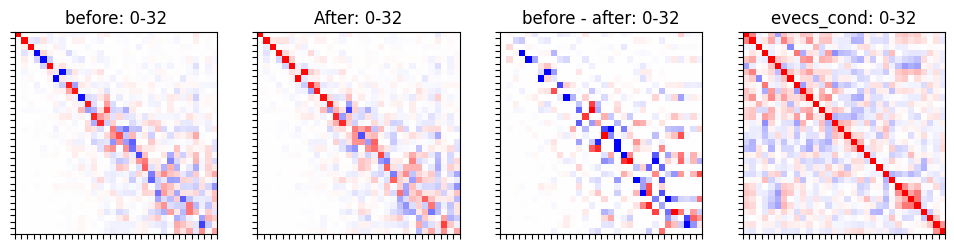

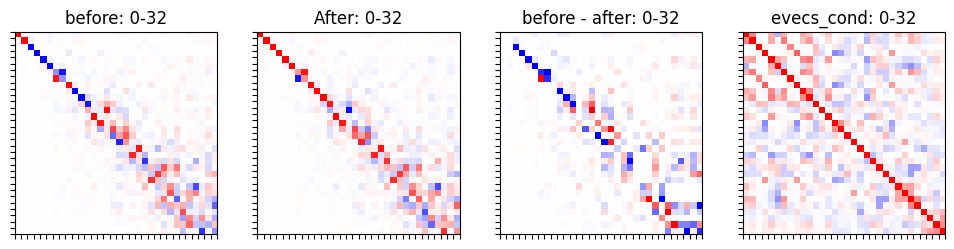

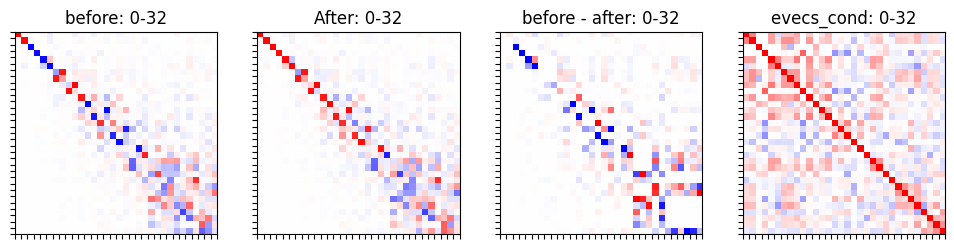

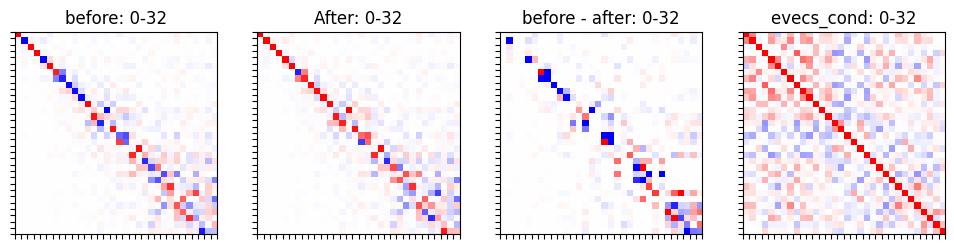

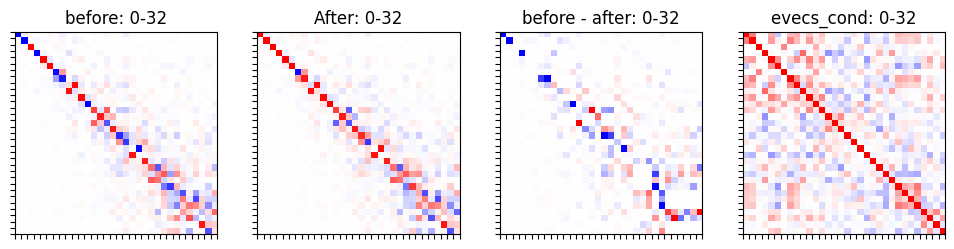

In [77]:
import my_code.utils.plotting_utils as plotting_utils

l = 0
h = 32


# rand_idx = np.random.choice(len(dataset_double), 10, replace=False)

Cxy_dataset_3dc = []

for i in range(5):
    C_xy_corr, C_xy_before, evecs_cond = get_corrected_data(
        data=dataset_3dc[i],
        net=net,
        net_input_type=input_type,
        num_evecs=32
    )
    
    Cxy_dataset_3dc.append((C_xy_corr, evecs_cond))

    fig, axs = plt.subplots(1, 4, figsize=(12, 5))

    # plotting_utils.plot_Cxy(fig, axs[0], dataset_double[i]['second']['C_gt_xy'][0],
    #                         'large', l, h, show_grid=False, show_colorbar=False)
    plotting_utils.plot_Cxy(fig, axs[0], C_xy_before,
                            'before', l, h, show_grid=False, show_colorbar=False)
    # plotting_utils.plot_Cxy(fig, axs[2], dataset_double[i]['second']['C_gt_xy'][0][:32,:32] -C_xy_before,
    #                         'large - before', l, h, show_grid=False, show_colorbar=False)
    plotting_utils.plot_Cxy(fig, axs[1], C_xy_corr,
                            'After', l, h, show_grid=False, show_colorbar=False)
    plotting_utils.plot_Cxy(fig, axs[2],
                            C_xy_before - C_xy_corr,
                            'before - after', l, h, show_grid=False, show_colorbar=False)    
    plotting_utils.plot_Cxy(fig, axs[3], evecs_cond,
                            'evecs_cond', l, h, show_grid=False, show_colorbar=False)

    plt.show()

In [53]:
scene.geometry.clear()

rand_idx_train = range(5)

for i in range(5):
    # scene.add_geometry(trimesh.Trimesh(
    #     vertices=dataset[i]['verts'] + torch.tensor([i, 0, 0]),
    #     faces=dataset[i]['faces']))
    # scene.add_geometry(trimesh.Trimesh(
    #     vertices=dataset_3dc[i]['second']['verts'] + torch.tensor([i, 0.1, 0]),
    #     faces=dataset_3dc[i]['second']['faces']))
    
    data_i = dataset[i]
    data_3dc_i = dataset_3dc[i]['second']
    
    assert torch.allclose(data_i['verts'], data_i['verts'])
    assert torch.allclose(data_i['faces'], data_i['faces'])
    
    
# axis = trimesh.creation.axis(axis_length=1)
# scene.add_geometry(axis)
# scene.show()

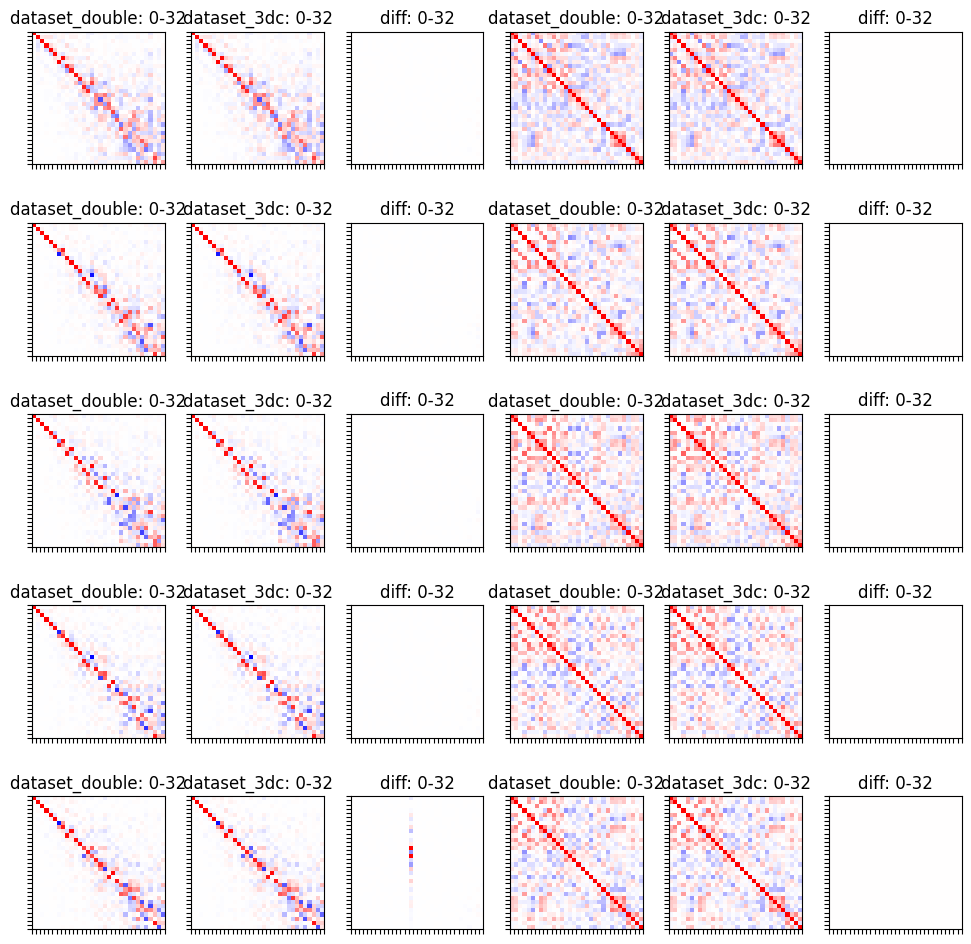

In [72]:
fig, axs = plt.subplots(5, 6, figsize=(12, 12))

for i in range(5):
    plotting_utils.plot_Cxy(fig, axs[i, 0], Cxy_dataset_double[i][0],
                            'dataset_double', l, h, show_grid=False, show_colorbar=False)
    plotting_utils.plot_Cxy(fig, axs[i, 1], Cxy_dataset_3dc[i][0],
                            'dataset_3dc', l, h, show_grid=False, show_colorbar=False)
    plotting_utils.plot_Cxy(fig, axs[i, 2], Cxy_dataset_double[i][0] - Cxy_dataset_3dc[i][0],
                            'diff', l, h, show_grid=False, show_colorbar=False)
    
    plotting_utils.plot_Cxy(fig, axs[i, 3], Cxy_dataset_double[i][1],
                            'dataset_double', l, h, show_grid=False, show_colorbar=False)
    plotting_utils.plot_Cxy(fig, axs[i, 4], Cxy_dataset_3dc[i][1],
                            'dataset_3dc', l, h, show_grid=False, show_colorbar=False)
    plotting_utils.plot_Cxy(fig, axs[i, 5], Cxy_dataset_double[i][1] - Cxy_dataset_3dc[i][1],
                            'diff', l, h, show_grid=False, show_colorbar=False)
    
plt.show()

In [15]:
# read /home/s94zalek_hpc/shape_matching/data/SURREAL_full/full_datasets/dataset_3dc_corrected_noAug_32/train/C_gt_xy_0_11500.txt

import numpy as np

C_prev = np.loadtxt('/home/s94zalek_hpc/shape_matching/data/SURREAL_full/full_datasets/dataset_3dc_corrected_noAug_32/train/C_gt_xy_0_11500.txt')

In [17]:
C_prev.shape

(11500, 1024)

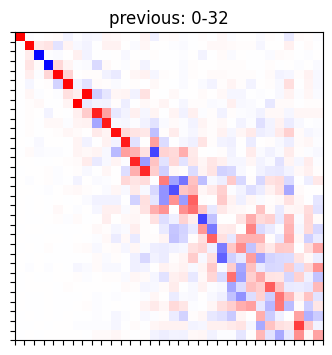

In [19]:
fig, axs = plt.subplots(1, 1, figsize=(4, 4))

plotting_utils.plot_Cxy(fig, axs, C_prev[0].reshape(32, 32),
                            'previous', l, h, show_grid=False, show_colorbar=False)

plt.show()

In [24]:
# open /home/s94zalek_hpc/shape_matching/my_code/experiments/sign_double_start_0_feat_32_6block_factor4_dataset_SURREAL_train_rot_180_180_180_normal_True_noise_0.0_-0.05_0.05_lapl_mesh_scale_0.9_1.1_wks/40000.pth
chkpt_1 = torch.load('/home/s94zalek_hpc/shape_matching/my_code/experiments/sign_double_start_0_feat_32_6block_factor4_dataset_SURREAL_train_rot_180_180_180_normal_True_noise_0.0_-0.05_0.05_lapl_mesh_scale_0.9_1.1_wks/40000.pth')

# open /home/s94zalek_hpc/shape_matching/my_code/experiments/sign_estimator_no_aug/40000.pth
chkpt_2 = torch.load('/home/s94zalek_hpc/shape_matching/my_code/experiments/sign_estimator_no_aug/40000.pth')

chkpt_3 = torch.load('/home/s94zalek_hpc/shape_matching/my_code/experiments/sign_double_start_0_feat_32_6block_factor4_dataset_SURREAL_wks/40000.pth')

In [ ]:
print(chkpt_2)

In [ ]:
# read and show /home/s94zalek_hpc/shape_matching/data_sign_training/train/SURREAL_train_rot_180_180_180_normal_True_noise_0.0_-0.05_0.05_lapl_mesh_scale_0.9_1.1/off/0000.off

import trimesh

scene.geometry.clear()

scene.add_geometry(trimesh.load_mesh('/home/s94zalek_hpc/shape_matching/data_sign_training/train/SURREAL_train_rot_180_180_180_normal_True_noise_0.0_-0.05_0.05_lapl_mesh_scale_0.9_1.1/off/0000.off'))

axis = trimesh.creation.axis(axis_length=1)

scene.add_geometry(axis)

scene.show()

In [ ]:
# TODO: in a py file, use zip dataset to check sign estimation of 2 checkpoints

In [31]:
tqdm._instances.clear()

In [6]:
dataset_3dc[10]

{'first': {'id': tensor(-1),
  'verts': tensor([[ 0.0643,  0.5906,  0.1324],
          [ 0.0606,  0.5795,  0.1361],
          [ 0.0685,  0.5792,  0.1295],
          ...,
          [-0.0187,  0.5694,  0.0521],
          [-0.0190,  0.5701,  0.0534],
          [-0.0200,  0.5678,  0.0546]]),
  'faces': tensor([[   3,    0,    2],
          [   2,    0,    1],
          [   5,    4,    1],
          ...,
          [4805, 3511, 6309],
          [3511, 1330, 6309],
          [6309, 1330, 4687]]),
  'corr': tensor([   0,    1,    2,  ..., 6887, 6888, 6889]),
  'evecs': tensor([[-1.0000, -0.9561,  0.0091,  ..., -2.5006,  0.4422, -0.7772],
          [-1.0000, -0.9537,  0.0091,  ..., -2.2478,  0.4013, -0.7261],
          [-1.0000, -0.9533,  0.0091,  ..., -2.9054,  0.1760, -0.7376],
          ...,
          [-1.0000, -0.9409,  0.0086,  ...,  5.9410,  0.9227,  0.6832],
          [-1.0000, -0.9412,  0.0086,  ...,  5.9309,  0.9357,  0.6755],
          [-1.0000, -0.9410,  0.0086,  ...,  5.9141,  0.943

In [12]:
import torch

dataloader_3dc = torch.utils.data.DataLoader(dataset_3dc, batch_size=1, shuffle=False,
                                             num_workers=16, persistent_workers=True)

In [13]:
tqdm._instances.clear()

In [14]:
from tqdm import tqdm

with tqdm(range(len(dataset_3dc))) as iterator:
    for i, data in enumerate(dataloader_3dc):
        iterator.update(1)

  0%|                                                                                                            | 0/230000 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x1521b4717550>
Traceback (most recent call last):
  File "/home/s94zalek_hpc/.conda/envs/fmnet/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/s94zalek_hpc/.conda/envs/fmnet/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/home/s94zalek_hpc/.conda/envs/fmnet/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x1521b4717550>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x1521b4717550>
Traceba

KeyboardInterrupt: 